In [1]:
import numpy as np
import sys
import pickle
import scipy.optimize as optimize
import scipy.interpolate as interpolate
from scipy.stats import norm
from scipy.special import jv
from scipy.stats import wishart
import time
from scipy.stats import norm as normal
from scipy.stats import multivariate_normal
import emcee
import pickle
from cosmology import *
import scipy.integrate as integrate
import scipy.constants as sc


def flat_prior(theta, prior_args):
    
    lower = prior_args[0]
    upper = prior_args[1]
    
    # Test each parameter against prior limits
    for a in range(0, len(theta)):
        
        if theta[a] > upper[a] or theta[a] < lower[a]:
            return 0
        
    return np.prod(upper-lower)

def gaussian_prior_draw(prior_args):
    
    mean = prior_args[0]
    C = prior_args[1]
    return multivariate_normal.rvs(mean=mean, cov=C)

def truncated_gaussian_prior_draw(prior_args):

    mean = prior_args[0]
    C = prior_args[1]
    lower = prior_args[2]
    upper = prior_args[3]
    
    # While outside possible range
    P = 0
    while P == 0:
        x = gaussian_prior_draw([mean, C])
        P = flat_prior(x, [lower, upper])
    return x

def truncated_gaussian_prior(theta, prior_args):
    
    mean = prior_args[0]
    C = prior_args[1]
    lower = prior_args[2]
    upper = prior_args[3]
    
    return flat_prior(theta, [lower, upper])*multivariate_normal.pdf(theta, mean=mean, cov=C)

# Compute the data vector
def power_spectrum(theta, sim_args):
    
    # Unpack sim args
    pz_fid = sim_args[0]
    modes = sim_args[1]
    N = sim_args[3]
    nz = len(pz_fid)

    # Evaluate the required (derived) cosmological parameters
    omm = theta[0]
    sigma8 = theta[1]*np.sqrt(0.3/theta[0])
    omb = theta[2]
    h = theta[3]
    ns = theta[4]
    omde = 1.0 - omm
    hubble = h*100
    w0 = -1.
    wa = 0
    omnu = 0
    omk = 0
    
    pz = pz_fid
    
    # Initialize cosmology object
    cosmo = cosmology(Omega_m=omm, Omega_de=omde, Omega_b=omb, h=h, n=ns, sigma8=sigma8, w0=w0, wa=0)

    # Numerics parameters
    zmax = 2
    rmax = cosmo.a2chi(z2a(zmax))
    power_zpoints = int(np.ceil(5*zmax))
    power_kpoints = 200
    distance_zpoints = int(np.ceil(10*zmax))
    wpoints = int(np.ceil(15*zmax))
    kmax = 10
    clpoints = 2**7 + 1

    # Compute the matter power spectrum at the cosmology
    z = np.linspace(0, zmax, power_zpoints)
    logk = np.log(np.logspace(-3, np.log10(kmax), power_kpoints))
    logpkz = np.log(cosmo.pk(np.exp(logk), z2a(z)))

    # 2D linear interpolator for P(k;z)
    logpkz = interpolate.RectBivariateSpline(logk, z, logpkz, kx=3, ky=3)

    # Generate list of z-values at which we will compute r(z), initialize array of r-values to hold computed values of r(z)
    zvalues = np.linspace(0, zmax, distance_zpoints)
    rvalues = np.zeros((len(zvalues)))

    # Perform integration to compute r(z) at specified points according to cosmology
    for i in range(0, len(zvalues)):
        rvalues[i] = integrate.romberg(lambda x: 1.0/np.sqrt(omm*(1+x)**3 + omnu*(1+x)**4+omk*(1+x)**2 + omde*np.exp(-3*wa*x/(1+x))*(1+x)**(3*(1+w0+wa))), 0, zvalues[i], divmax=100)

    # Generate interpolation functions to give r(z) and z(r) given cosmology
    r = interpolate.InterpolatedUnivariateSpline(zvalues, rvalues, k = 3)
    z = interpolate.InterpolatedUnivariateSpline(rvalues, zvalues, k = 3)

    # Set the maximum comoving distance corresponding to the maximum redshift
    rmax = rvalues[-1]

    # Compute lensing weights...

    w = []
    
    # Compute the weight function associated with each bin in turn, over r-points and then interpolate
    for i in range(0, nz):

        # r-points to evaluate weight at before interpolation
        rpoints = np.linspace(0, rmax, wpoints)

        # Initialize weights
        weight = np.zeros(wpoints)

        # Compute integral for the rest of the points
        for j in range(1, wpoints):
            x = np.linspace(rpoints[j], rmax, 2**6 + 1)
            dx = x[1] - x[0]
            intvals = rpoints[j]*pz[i](z(x)) * h*cosmo.H(z2a(z(x))) * (1.0/hubble) * (x-rpoints[j])/x
            weight[j] = integrate.romb(intvals, dx)

        # Interpolate (generate interpolation function) and add interpolation function to the array w
        interp = interpolate.InterpolatedUnivariateSpline(rpoints, weight, k = 3)
        w.append(interp)
    
    # Tensor for cls
    cls = np.zeros((nz, nz, len(modes)))

    # Pull required cosmological parameters out of cosmo
    r_hubble = sc.c/(1000*hubble)
    A = (1000/sc.c)**3*(9*omm**2*hubble**3/(4*h**3))

    # Compute Cls
    for L in range(len(modes)):
        l = modes[L]
        rs = np.linspace(r(l/(h*r_hubble*kmax)), rmax, clpoints)
        dr = rs[1] - rs[0]
        for i in range(0, nz):
            for j in range(i, nz):
                intvals = ((l/(l+0.5))**4)*A*(1.0/rs**2)*w[i](rs)*w[j](rs) * (1+z(rs))**2 * np.exp(logpkz.ev(np.log((l+0.5)/(h*rs*r_hubble)), z(rs)))
                cls[i, j, L] = integrate.romb(intvals, dr)
                cls[j, i, L] = cls[i, j, L]
        cls[:,:,L] = cls[:,:,L] + N
                
    return cls


def log_likelihood(theta, d, sim_args, prior_args):

    # Unpack args
    pz_fid = sim_args[0]
    modes = sim_args[1]
    nl = sim_args[2]
    N = sim_args[3]
    nz = len(pz_fid)
    nmodes = len(modes)
    
    if truncated_gaussian_prior(theta, prior_args) == 0:
        return -1e300
    else:
        # Compute power spectrum
        C = power_spectrum(theta, sim_args)

        # iterate log-likelihood
        lnL = 0
        for l in range(len(modes)):
            lnL += -0.5*nl[l]*np.log(np.linalg.det(C[:,:,l])) - 0.5*nl[l]*np.trace(np.dot(np.linalg.inv(C[:,:,l]), d[:,:,l]))

        if np.isnan(lnL) == True:
            return -1e300
        else:
            return lnL + np.log(truncated_gaussian_prior(theta, prior_args))

In [2]:
### Euclid-like survey ###

# n(z)
pz = pickle.load(open('pz_euclid.pkl', 'rb'))

# Set up fiducial parameters and binning
theta_fiducial = np.array([0.3, 0.8, 0.05, 0.70, 0.96])
nz = 10
npar = 5

# Define the priors
lower = np.array([0, 0.4, 0, 0.4, 0.7])
upper = np.array([1, 1.2, 0.1, 1.0, 1.3])
prior_mean = theta_fiducial
sigmas = np.zeros(npar)
sigmas[0:5] = np.array([0.1, 0.1, 0.05, 0.3, 0.3])
Q = np.eye(npar)*sigmas**2
Qinv = np.linalg.inv(Q)
prior_args = [prior_mean, Q, lower, upper]

lmax = 3000
lmin = 10
nmodes = 10
modes_edges = np.logspace(np.log10(lmin), np.log10(lmax), nmodes+1)
modes = (modes_edges[0:-1] + modes_edges[1:])/2
l = np.arange(lmin, lmax)
nl = np.array([sum((2*l[(l >= modes_edges[i])*(l < modes_edges[i+1])] + 1)) for i in range(len(modes))], dtype=int)

# Number of effective modes
A_sky = 15000*(np.pi/180)**2
f_sky = A_sky/(4*np.pi)
nl = np.array(nl*f_sky, dtype=int)

# Noise covariance
sigma_e = 0.3
nbar = 3*(60*180./np.pi)**2
N = (sigma_e**2/nbar)*np.eye(nz)

# Simulation arguments
sim_args = [pz, modes, nl, N]

# Fiducial power spectrum
d = power_spectrum(theta_fiducial, sim_args)

In [40]:
nh = 100
h = np.linspace(0.65, 0.75, nh)
ll = np.zeros(nh)
for i in range(nh):
    theta = np.copy(theta_fiducial)
    theta[3] = h[i]
    ll[i] = log_likelihood(theta, d, sim_args, prior_args)

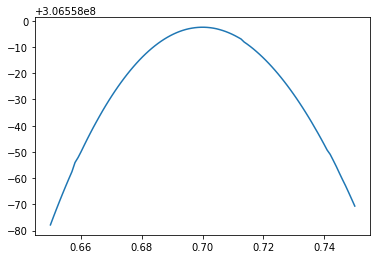

In [41]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(h, ll)

In [42]:
LL = interpolate.InterpolatedUnivariateSpline(h, ll, k = 3)

In [43]:
LL.derivative(n=2)(0.7)

array(-57217.51535833)

In [32]:
nb = 30
b = np.linspace(0.04, 0.06, nb)
ll = np.zeros(nb)
for i in range(nb):
    theta = np.copy(theta_fiducial)
    theta[2] = b[i]
    ll[i] = log_likelihood(theta, d, sim_args, prior_args)

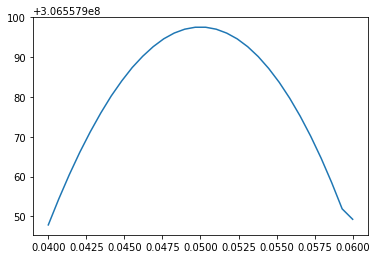

In [33]:
plt.plot(b, ll)

In [34]:
LL = interpolate.InterpolatedUnivariateSpline(b, ll, k = 3)
LL.derivative(n=2)(0.05)

array(-1023067.18811393)